<a href="https://colab.research.google.com/github/varshitha775/FMML_LABS_PROJECTS_26/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-20 13:31:05--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.48MB/s    in 0.6s    

2025-02-20 13:31:07 (1.48 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


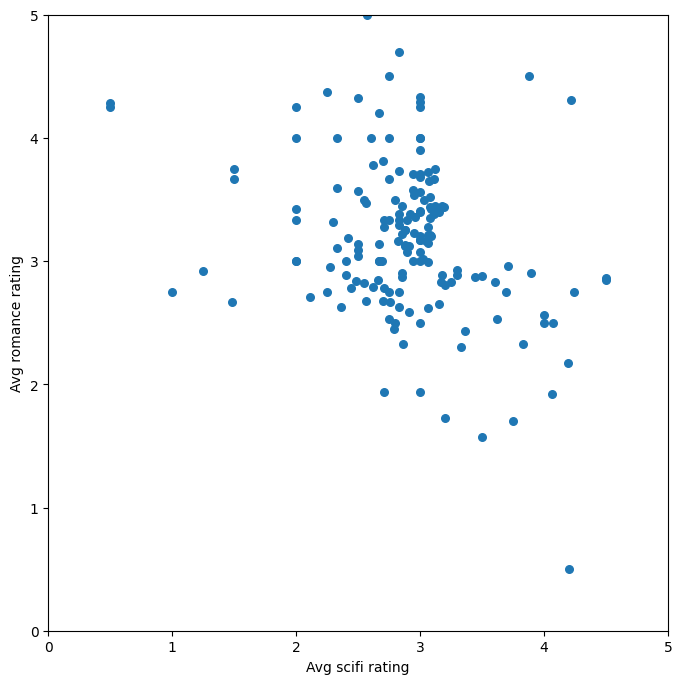

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

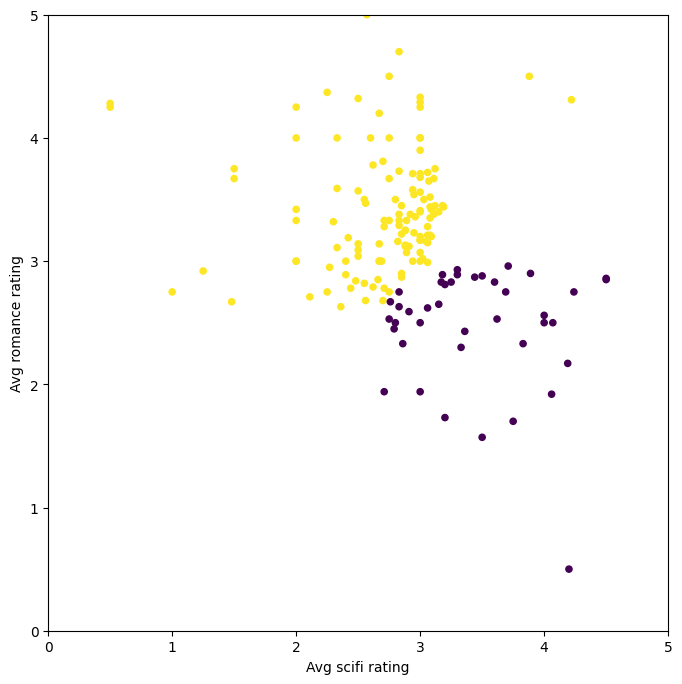

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

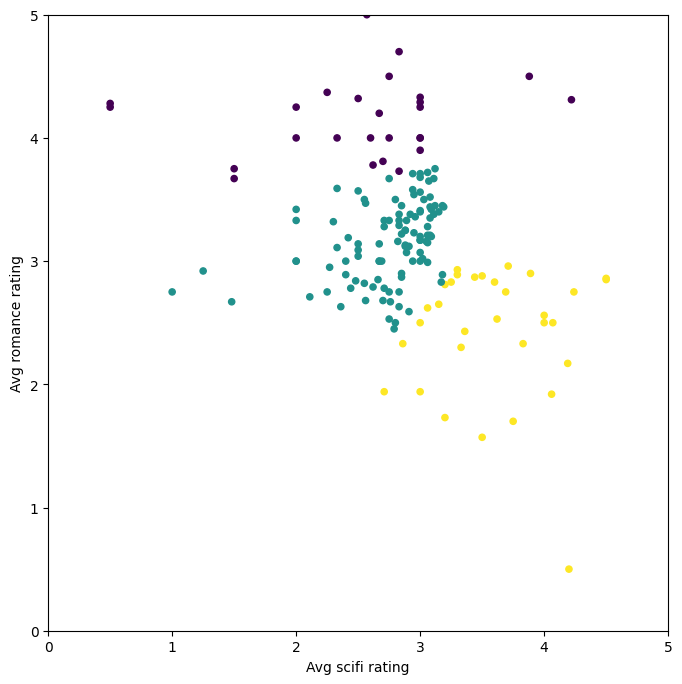

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


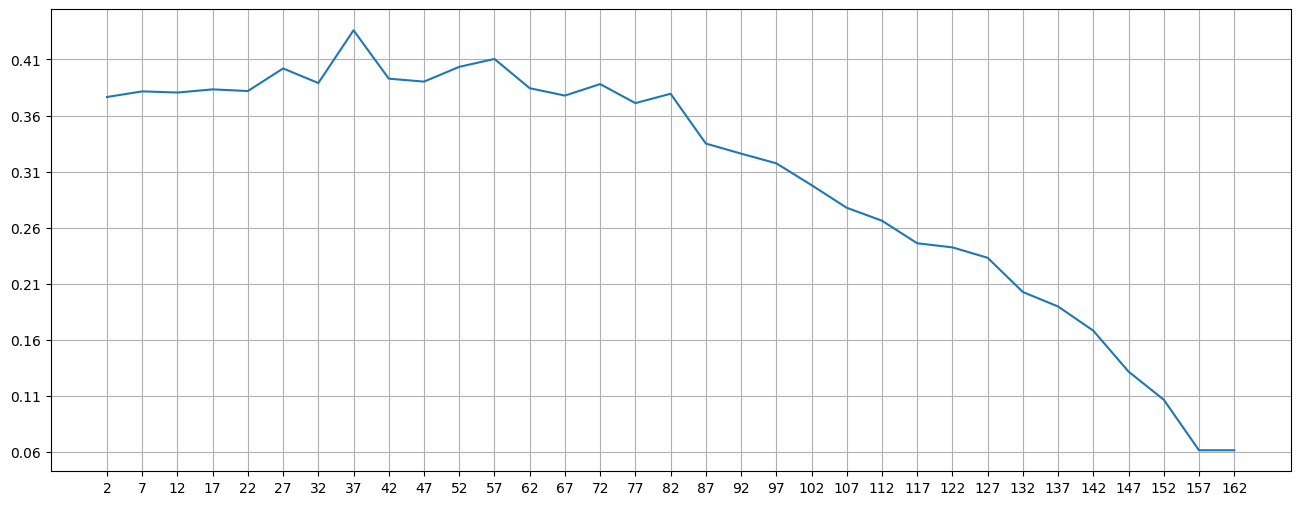

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



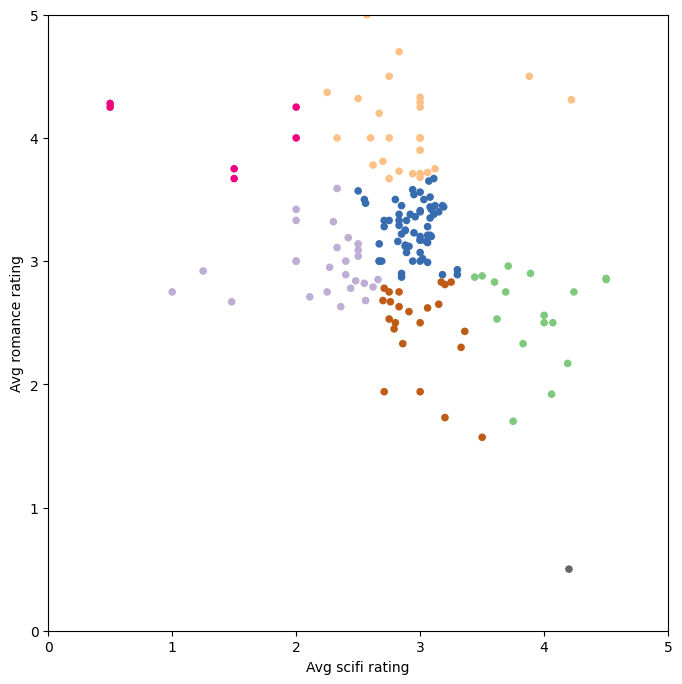

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


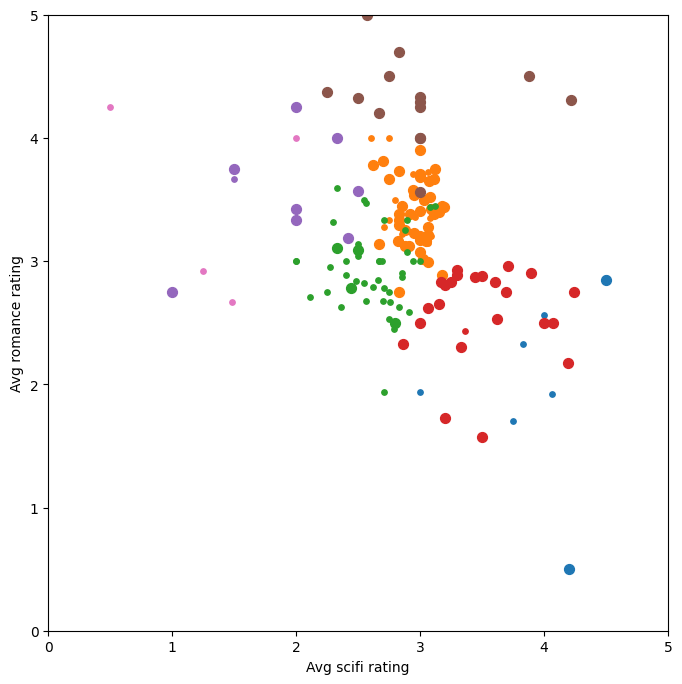

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

For k = 2, Silhouette Score = 0.4022
For k = 3, Silhouette Score = 0.3646
For k = 4, Silhouette Score = 0.3317
For k = 5, Silhouette Score = 0.3201
For k = 6, Silhouette Score = 0.3421
For k = 7, Silhouette Score = 0.3503
For k = 8, Silhouette Score = 0.3375
For k = 9, Silhouette Score = 0.3596
For k = 10, Silhouette Score = 0.3469


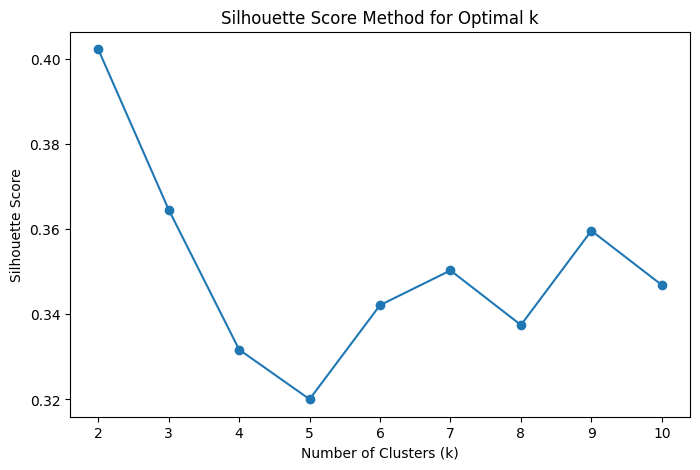

✅ Optimal number of clusters: 2


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # <-- Added for NaN handling

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with column mean
genre_ratings_filled = imputer.fit_transform(genre_ratings)

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(genre_ratings_filled)

# Clustering process remains the same...
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k = {k}, Silhouette Score = {silhouette_avg:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"✅ Optimal number of clusters: {optimal_k}")


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [17]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For k = 2, Silhouette Score = 0.4022
For k = 3, Silhouette Score = 0.3646
For k = 4, Silhouette Score = 0.3317
For k = 5, Silhouette Score = 0.3201
For k = 6, Silhouette Score = 0.3421
For k = 7, Silhouette Score = 0.3503
For k = 8, Silhouette Score = 0.3375
For k = 9, Silhouette Score = 0.3596
For k = 10, Silhouette Score = 0.3469


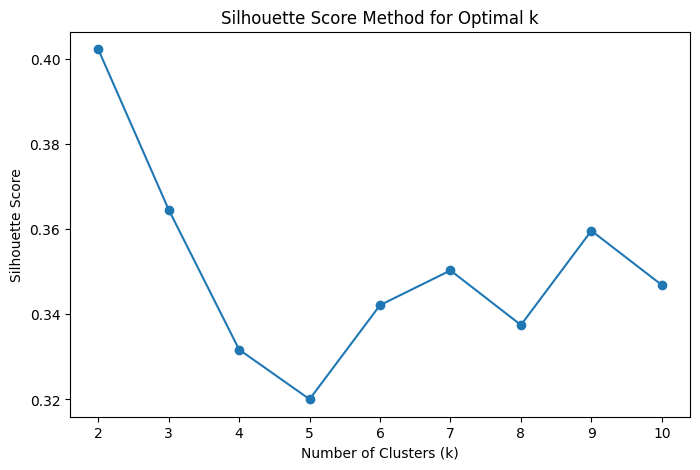

✅ Optimal number of clusters: 2
title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
480                     5.0                               5.0   
474                     3.0                               5.0   
68                      3.5                               3.0   
414                     5.0                               5.0   
590                     5.0                               4.5   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
480                     4.0                               4.5   
474                     4.0                               4.5   
68                      2.0                               3.5   
414                     5.0                               4.0   
590                     4.5                               3.5   

title   Matrix, The (1999)  Star Wars: Episode IV - A Ne

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handle missing values
imputer = SimpleImputer(strategy='mean')
genre_ratings_filled = imputer.fit_transform(genre_ratings)

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(genre_ratings_filled)

# Clustering process
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k = {k}, Silhouette Score = {silhouette_avg:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"✅ Optimal number of clusters: {optimal_k}")

# Fix for append issue in sort_by_rating_density
def sort_by_rating_density(df, n_movies, n_users):
    df = df.loc[:, df.count().sort_values(ascending=False).index[:n_movies]]  # Select top movies
    df = df.loc[df.count(axis=1).sort_values(ascending=False).index[:n_users], :]  # Select top users
    return df

# Ensure user_movie_ratings is a DataFrame
if not isinstance(user_movie_ratings, pd.DataFrame):
    raise ValueError("user_movie_ratings must be a pandas DataFrame")

# Apply sorting function
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, 30, 18)
print(most_rated_movies_users_selection.head())


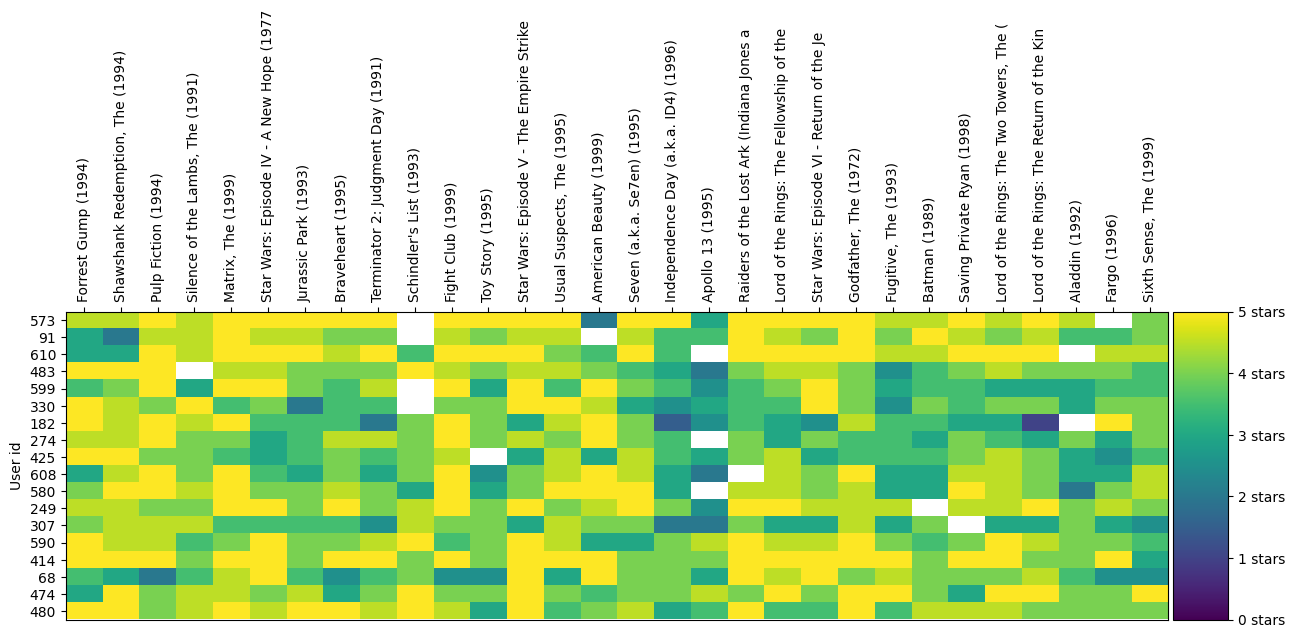

In [20]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [22]:
import numpy as np
import pandas as pd

# Pivot the dataset to get user-movie rating matrix
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns='title', values='rating')

# Function to get the top N most-rated movies
def get_most_rated_movies(df, top_n):
    top_movies = df.count().sort_values(ascending=False).head(top_n).index  # Get top N movies
    return df[top_movies]

# Select top 1000 most rated movies and replace NaNs with 0
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).fillna(0)

# Print the first few rows to verify
print(most_rated_movies_1k.head())


title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
1                       4.0                               0.0   
2                       0.0                               3.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
5                       0.0                               3.0   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
1                       3.0                               4.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       1.0                               5.0   
5                       5.0                               0.0   

title   Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
userId         

In [23]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# 20 Clusters with Correct Algorithm
predictions = KMeans(n_clusters=20, algorithm='lloyd', random_state=42).fit_predict(sparse_ratings)

# Function to get top-rated movies
def get_most_rated_movies(df, top_n):
    top_movies = df.count().sort_values(ascending=False).head(top_n).index
    return df[top_movies]

# Select the most rated movies and assign cluster groups
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(),
                       pd.DataFrame({'group': predictions})], axis=1)

# Print sample clusters
print(clustered.head())

# Optional: Call function to visualize clusters (if implemented)
# draw_movie_clusters(clustered, max_users, max_movies)


   userId  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
0       1                  4.0                               NaN   
1       2                  NaN                               3.0   
2       3                  NaN                               NaN   
3       4                  NaN                               NaN   
4       5                  NaN                               3.0   

   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  Matrix, The (1999)  \
0                  3.0                               4.0                 5.0   
1                  NaN                               NaN                 NaN   
2                  NaN                               NaN                 NaN   
3                  1.0                               5.0                 1.0   
4                  5.0                               NaN                 NaN   

   Star Wars: Episode IV - A New Hope (1977)  Jurassic Park (1993)  \
0                                       

### Predictions and Recommendation

     userId  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
18       19                  2.0                               NaN   
56       57                  4.0                               NaN   
155     156                  3.0                               4.5   
198     199                  2.0                               4.0   
201     202                  5.0                               4.0   

     Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
18                   NaN                               NaN   
56                   3.0                               5.0   
155                  5.0                               4.0   
198                  4.0                               4.0   
201                  4.0                               5.0   

     Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
18                  4.0                                        4.0   
56                  5.0                                        5.0

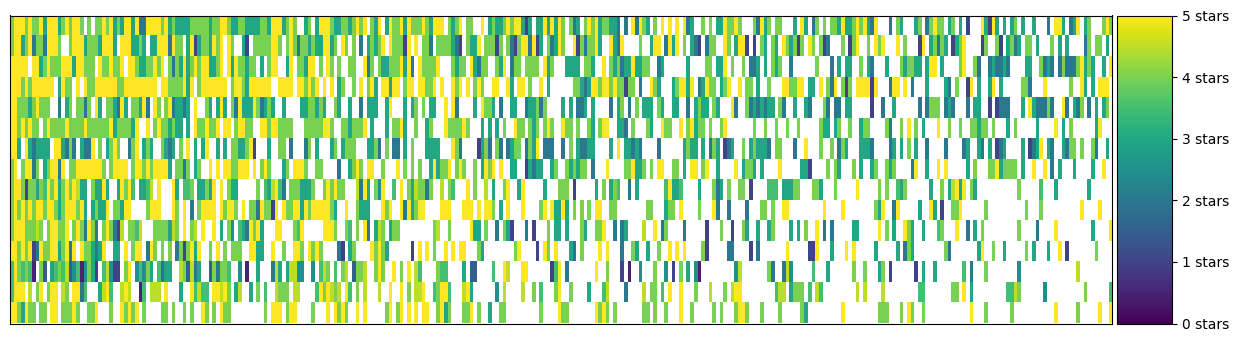

In [27]:
# Pick a cluster ID from the clusters above
cluster_number = 11

# Set parameters for filtering
n_users = 75
n_movies = 300

# Filter data for the selected cluster
cluster = clustered[clustered.group == cluster_number].copy()  # Copy to avoid SettingWithCopyWarning

# Drop only existing columns
columns_to_drop = [col for col in ['index', 'group'] if col in cluster.columns]
cluster.drop(columns=columns_to_drop, axis=1, inplace=True)

# Print cluster preview
print(cluster.head())

# Sort and visualize
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)


In [28]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

3.8076923076923075

In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Ferris Bueller's Day Off (1986)                                                   4.187500
Groundhog Day (1993)                                                              4.500000
Blade Runner (1982)                                                               4.500000
Being John Malkovich (1999)                                                       4.533333
L.A. Confidential (1997)                                                          4.233333
Reservoir Dogs (1992)                                                             4.533333
Princess Bride, The (1987)                                                        4.533333
Forrest Gump (1994)                                                               3.833333
Star Wars: Episode IV - A New Hope (1977)                                         4.166667
Matrix, The (1999)                                                                4.333333
Pulp Fiction (1994)                                                               4.607143

In [29]:
cluster

,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),userId,L.A. Confidential (1997),Blade Runner (1982),Star Wars: Episode IV - A New Hope (1977),Reservoir Dogs (1992),Shakespeare in Love (1998),Ferris Bueller's Day Off (1986),"Fish Called Wanda, A (1988)",Back to the Future (1985),...,Monty Python's And Now for Something Completely Different (1971),Wallace & Gromit: The Wrong Trousers (1993),"Godfather: Part III, The (1990)",Mary Poppins (1964),Air Force One (1997),Blade (1998),Hoop Dreams (1994),Better Off Dead... (1985),Willy Wonka & the Chocolate Factory (1971),"Bridge on the River Kwai, The (1957)"
468,4.0,469,5.0,5.0,4.0,5.0,4.0,4.0,5.0,3.0,...,5.0,NaN,3.0,4.0,NaN,NaN,NaN,4.0,5.0,4.0
602,4.0,603,5.0,3.0,4.0,5.0,2.0,4.0,4.0,2.0,...,NaN,NaN,2.0,4.0,NaN,4.0,4.0,NaN,3.0,NaN
56,5.0,57,5.0,5.0,5.0,NaN,5.0,5.0,3.0,4.0,...,4.0,5.0,3.0,4.0,3.0,NaN,NaN,3.0,NaN,5.0
596,5.0,597,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,...,NaN,5.0,3.0,NaN,3.0,NaN,5.0,5.0,5.0,NaN
18,5.0,19,4.0,4.0,4.0,3.0,4.0,5.0,4.0,4.0,...,2.0,4.0,NaN,2.0,NaN,3.0,NaN,3.0,4.0,NaN
201,5.0,202,4.0,5.0,4.0,5.0,4.0,4.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN,NaN,NaN
216,5.0,217,3.0,NaN,5.0,3.0,2.0,3.0,3.0,3.0,...,NaN,4.0,NaN,NaN,4.0,2.0,NaN,NaN,3.0,NaN
554,4.0,555,NaN,4.0,5.0,5.0,2.0,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN
155,4.0,156,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.5,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
274,4.0,275,4.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0,...,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN


In [37]:
# Pick a user ID from the dataset
user_id = 7

# Check where the user belongs (use index, not 'index' column)
if user_id in clustered.index:
    cluster_number = clustered.loc[user_id, 'group']
    print(f"User {user_id} belongs to Cluster {cluster_number}")

    # Select the correct cluster
    cluster = clustered[clustered.group == cluster_number].drop(['group'], axis=1)

    # Proceed with recommendations
    user_2_ratings = cluster.loc[user_id, :]
    user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]
    avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').iloc[:, 1]
    recommended_movies = avg_ratings.sort_values(ascending=False).head(20)

    print("Top 20 Movie Recommendations for User", user_id)
    print(recommended_movies)

else:
    print(f"User {user_id} is not in any cluster. Try a different user.")


User 7 belongs to Cluster 0
Top 20 Movie Recommendations for User 7
Wallace & Gromit: A Close Shave (1995)                     5.000000
Wallace & Gromit: The Best of Aardman Animation (1996)     5.000000
Star Wars: Episode IV - A New Hope (1977)                  4.750000
The Imitation Game (2014)                                  4.500000
Star Wars: Episode V - The Empire Strikes Back (1980)      4.500000
Phenomenon (1996)                                          4.500000
Birdman: Or (The Unexpected Virtue of Ignorance) (2014)    4.500000
Clerks (1994)                                              4.400000
Pinocchio (1940)                                           4.250000
Sense and Sensibility (1995)                               4.214286
Toy Story (1995)                                           4.178571
Taxi Driver (1976)                                         4.166667
Carlito's Way (1993)                                       4.166667
Much Ado About Nothing (1993)                   

## Using Collaborative Filtering (With fast.ai)

In [38]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.1 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", 

In [39]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [40]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [41]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [42]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [43]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [44]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [45]:
dls.show_batch()

,user,title,rating
0,62,Apollo 13 (1995),3
1,933,Manon of the Spring (Manon des sources) (1986),3
2,693,Cat on a Hot Tin Roof (1958),4
3,653,Jaws (1975),3
4,116,In the Company of Men (1997),3
5,363,Don Juan DeMarco (1995),4
6,897,Star Trek IV: The Voyage Home (1986),4
7,868,Flirting With Disaster (1996),5
8,298,Psycho (1960),3
9,363,Sling Blade (1996),5


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [46]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [47]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.887991,0.969769,00:08
1,0.666975,0.909745,00:08
2,0.534787,0.893877,00:08
3,0.459389,0.875804,00:08
4,0.437908,0.872366,00:09


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [48]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [49]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [50]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [51]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3780),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3050), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3007), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2977), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2786), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2558), 'Stupids, The (1996)', 2.0),
 (tensor(-0.2552),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2498), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2408), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2391), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2334), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2331), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2283), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2259), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.217

Or the ones with the best bias:

In [52]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5913), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5670), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5595), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5583), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5544), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5496), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5373), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.4978), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4955), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4841), 'Treasure of the Sierra Madre, The (1948)', 4.1),
 (tensor(0.4784), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4691), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4660), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4575), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4546), 'Fugitive, The (1993)', 4.044642857142857)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [53]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [54]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [55]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3950), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.2522), "McHale's Navy (1997)"),
 (tensor(1.1442), 'Home Alone 3 (1997)'),
 (tensor(1.1386), 'Bio-Dome (1996)'),
 (tensor(1.1307), 'Turbulence (1997)'),
 (tensor(1.0840), 'Leave It to Beaver (1997)'),
 (tensor(1.0508), 'Stupids, The (1996)'),
 (tensor(1.0450), 'Super Mario Bros. (1993)'),
 (tensor(1.0304), 'Congo (1995)'),
 (tensor(1.0152), 'Halloween: The Curse of Michael Myers (1995)')]

And the worst:

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1523), 'Chinatown (1974)'),
 (tensor(-1.1458), 'Casablanca (1942)'),
 (tensor(-1.0884),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-1.0650), 'Persuasion (1995)'),
 (tensor(-1.0617), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0061), 'Secrets & Lies (1996)'),
 (tensor(-0.9920), 'Godfather, The (1972)'),
 (tensor(-0.9848), 'Close Shave, A (1995)'),
 (tensor(-0.9612), 'When We Were Kings (1996)'),
 (tensor(-0.9538), 'Wallace & Gromit: The Best of Aardman Animation (1996)')]

Same thing for our second dimension:

In [58]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [59]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1390), 'Braveheart (1995)'),
 (tensor(1.0751), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0747), 'Titanic (1997)'),
 (tensor(0.9353), 'Forrest Gump (1994)'),
 (tensor(0.8975), 'American President, The (1995)'),
 (tensor(0.8640), 'Field of Dreams (1989)'),
 (tensor(0.8573), "Schindler's List (1993)"),
 (tensor(0.8422), 'Independence Day (ID4) (1996)'),
 (tensor(0.8420), 'Star Wars (1977)'),
 (tensor(0.8404), 'Indiana Jones and the Last Crusade (1989)')]

In [60]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8815), 'Keys to Tulsa (1997)'),
 (tensor(-0.8396), 'Crumb (1994)'),
 (tensor(-0.8145), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.8000), 'Spice World (1997)'),
 (tensor(-0.7942), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7755), 'Trainspotting (1996)'),
 (tensor(-0.7711), 'Jude (1996)'),
 (tensor(-0.7695), 'Heavenly Creatures (1994)'),
 (tensor(-0.7576), 'To Die For (1995)'),
 (tensor(-0.7420), 'Clockwork Orange, A (1971)')]

And we can even plot the movies according to their scores on those dimensions:

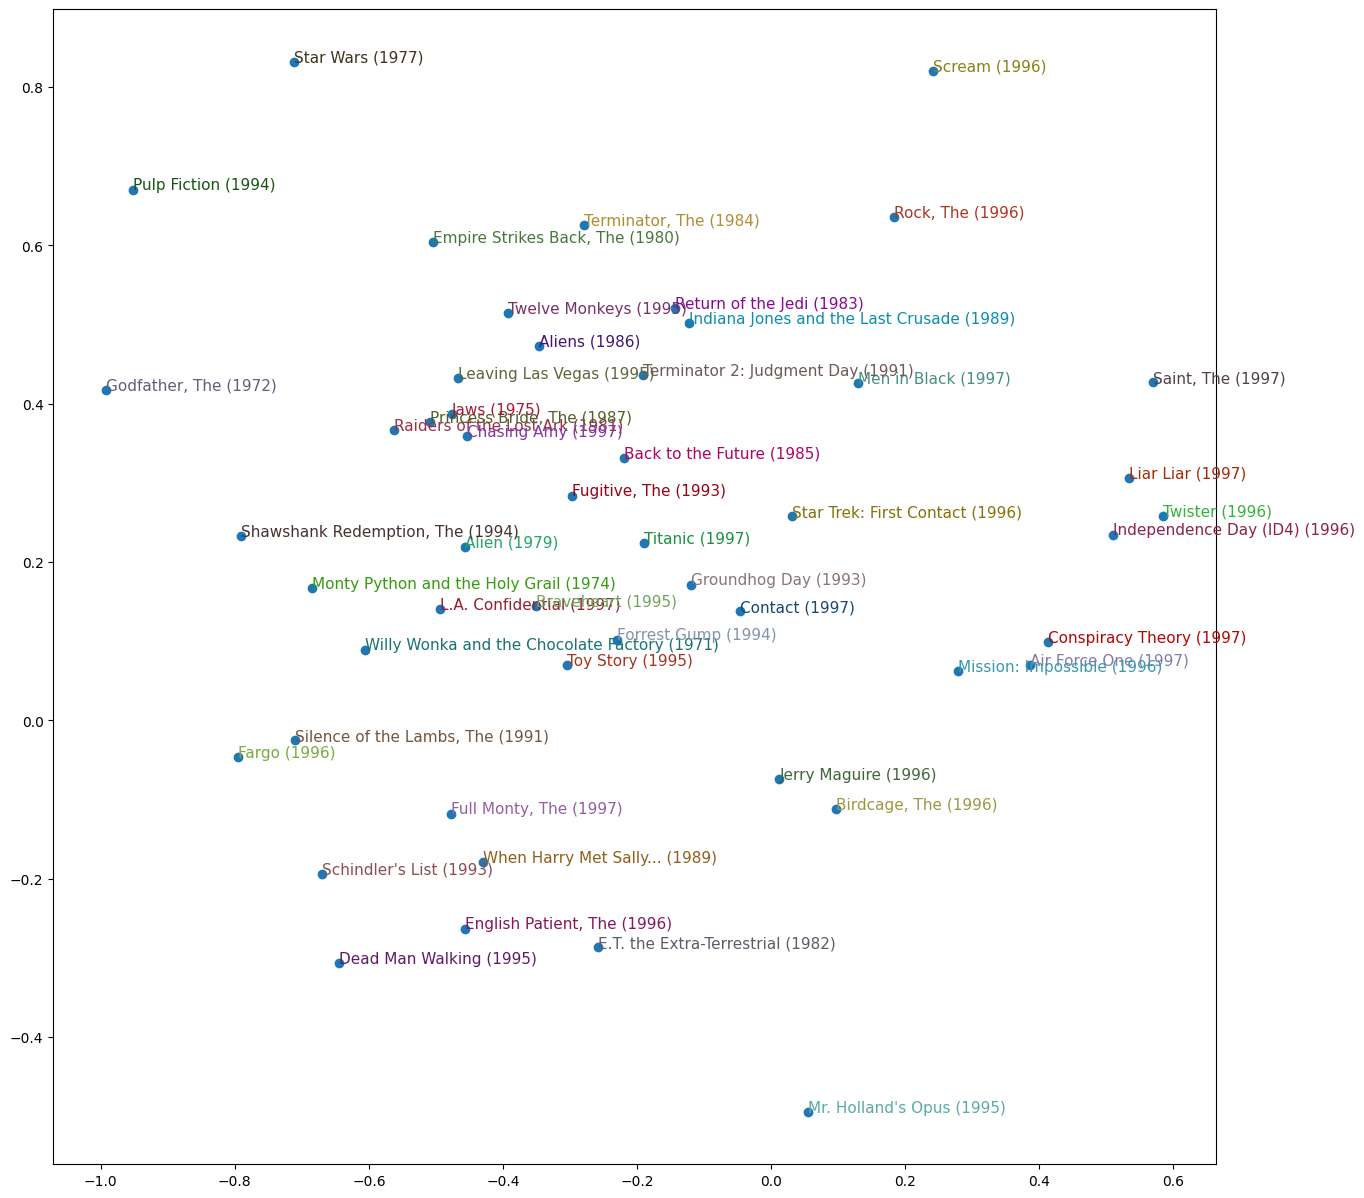

In [61]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [68]:
import time
import numpy as np
import pandas as pd

# ✅ Ensure Surprise is installed before proceeding
try:
    from surprise import SVD, Dataset, Reader
    from surprise.model_selection import GridSearchCV
except ImportError:
    print("⚠️ Surprise library not found. Installing now...")
    !pip install scikit-surprise
    from surprise import SVD, Dataset, Reader
    from surprise.model_selection import GridSearchCV

# ✅ Ensure the dataset exists
if 'ratings_title' not in globals():
    raise ValueError("❌ Error: 'ratings_title' dataset not found. Ensure it's loaded before running the script.")

# ✅ Load dataset (ensure correct format)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_title[['userId', 'movieId', 'rating']], reader)

# ✅ Define hyperparameter grid
param_grid = {
    'n_factors': [10, 50, 100],      # Number of latent factors
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1, 0.5],     # Regularization strength
    'n_epochs': [20, 50, 100]        # Number of training epochs
}

# ✅ Initialize GridSearchCV (Removed 'verbose' to prevent errors)
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# ✅ Run the search
start_time = time.time()
grid_search.fit(data)
training_time = time.time() - start_time

# ✅ Get the best parameters
best_params = grid_search.best_params['rmse']
best_score = grid_search.best_score['rmse']

# ✅ Display results
print("\n✅ Best Hyperparameters for RMSE:")
print(best_params)
print(f"🔹 Best RMSE Score: {best_score:.4f}")
print(f"🕒 Total Training Time: {training_time:.2f} seconds")



✅ Best Hyperparameters for RMSE:
{'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.1, 'n_epochs': 100}
🔹 Best RMSE Score: 0.8597
🕒 Total Training Time: 599.52 seconds


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# ✅ Load dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_title[['userId', 'movieId', 'rating']], reader)

# ✅ Define hyperparameters to test
param_grid = {
    'n_factors': [10, 50, 100],      # Latent features
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1, 0.5],     # Regularization
    'n_epochs': [20, 50, 100]        # Training iterations
}

# ✅ Store results
results = []

for n_factors in param_grid['n_factors']:
    for lr in param_grid['lr_all']:
        for reg in param_grid['reg_all']:
            for epochs in param_grid['n_epochs']:

                print(f"\n🚀 Training with: n_factors={n_factors}, lr_all={lr}, reg_all={reg}, n_epochs={epochs}")

                # Initialize model
                model = SVD(n_factors=n_factors, lr_all=lr, reg_all=reg, n_epochs=epochs, random_state=42)

                # Measure training time
                start_time = time.time()
                cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
                training_time = time.time() - start_time

                # Store results
                results.append({
                    'n_factors': n_factors,
                    'learning_rate': lr,
                    'regularization': reg,
                    'n_epochs': epochs,
                    'RMSE': np.mean(cv_results['test_rmse']),
                    'MAE': np.mean(cv_results['test_mae']),
                    'Training Time': training_time
                })

# ✅ Convert results to DataFrame
results_df = pd.DataFrame(results)

# ✅ Sort results by RMSE (best performance)
best_models = results_df.sort_values(by='RMSE').head(10)

print("\n✅ Top 10 Best Hyperparameter Configurations:")
print(best_models)

# ✅ Plot Training Time vs RMSE
plt.figure(figsize=(8, 5))
plt.scatter(results_df['Training Time'], results_df['RMSE'], color='blue', alpha=0.7)
plt.xlabel("Training Time (seconds)")
plt.ylabel("RMSE (Lower is Better)")
plt.title("Impact of Training Time on Model Performance")
plt.show()



🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.02, n_epochs=20

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.02, n_epochs=50

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.02, n_epochs=100

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.1, n_epochs=20

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.1, n_epochs=50

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.1, n_epochs=100

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.5, n_epochs=20

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.5, n_epochs=50

🚀 Training with: n_factors=10, lr_all=0.002, reg_all=0.5, n_epochs=100

🚀 Training with: n_factors=10, lr_all=0.005, reg_all=0.02, n_epochs=20

🚀 Training with: n_factors=10, lr_all=0.005, reg_all=0.02, n_epochs=50

🚀 Training with: n_factors=10, lr_all=0.005, reg_all=0.02, n_epochs=100

🚀 Training with: n_factors=10, lr_all=0.005, reg_all=0.1, n_epochs=20

🚀 Training with: n_factors=10, lr_all=0.005, reg_all=0.1, n_epochs